<a href="https://colab.research.google.com/github/ShabnaIlmi/Data-Science-Group-Project/blob/End_User_Risk_Prediction/DSGP_UserData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from matplotlib.ticker import LogLocator, FuncFormatter
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [43]:
# Mounting the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
# Loading the dataset with the proper delimiter (semicolon)
data = pd.read_excel('/content/drive/MyDrive/DSGP_User/Stock report.xlsx', sheet_name='TCC')

# Displaying the first few rows of the data
data.head()


,Warehouse,Product code,Invoice No,Transaction Date,UOM,Received Qty,Issued Qty,Customer name
0,Opening stock - 09.10.2024,NaN,NaN,NaT,NaN,16020.0,0.0,NaN
1,B4,H2O2-50%-IG-TCC-BANGLADESH,SI-N/10/24/197,2024-10-11,KG,NaN,150.0,PETTAH CHEMICAL
2,B4,H2O2-50%-IG-TCC-BANGLADESH,SI-N/10/24/205,2024-10-11,KG,NaN,30.0,PIYARA WASHING ENTERPRISES
3,B4,H2O2-50%-IG-TCC-BANGLADESH,SI-N/10/24/217,2024-10-12,KG,NaN,180.0,RIVINTA DRY AND WASHING
4,B4,H2O2-50%-IG-TCC-BANGLADESH,SI-N/10/24/240,2024-10-15,KG,NaN,60.0,SN PRODUCTS


In [45]:
# Displaying information
print("Displaying data information")
data.info()

Displaying data information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Warehouse         43 non-null     object        
 1   Product code      41 non-null     object        
 2   Invoice No        41 non-null     object        
 3   Transaction Date  41 non-null     datetime64[ns]
 4   UOM               41 non-null     object        
 5   Received Qty      3 non-null      float64       
 6   Issued Qty        42 non-null     float64       
 7   Customer name     41 non-null     object        
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 5.6+ KB


In [46]:
# Identifying categorical and numerical columns
categorical_cols = data.select_dtypes(include=['object']).columns
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns

# Displaying the categorical features
print("Categorical Features:")
print(categorical_cols)


Categorical Features:
Index(['Warehouse', 'Product code', 'Invoice No', 'UOM', 'Customer name'], dtype='object')


In [47]:
# Displaying the unique values and their counts relevant to each categorical column
for col in categorical_cols:
    print(f"\nColumn: {col}")
    print(data[col].value_counts(), "\n")


Column: Warehouse
Warehouse
B4                            41
Opening stock - 09.10.2024     1
Total                          1
Name: count, dtype: int64 


Column: Product code
Product code
H2O2-50%-IG-TCC-BANGLADESH    41
Name: count, dtype: int64 


Column: Invoice No
Invoice No
SI-N/10/24/197        1
AWT-SI-N/10/24/018    1
SI-N/10/24/504        1
SI-N/10/24/514        1
SI-S/10/24/263        1
SI-N/10/24/526        1
SI-S/10/24/279        1
SI-N/10/24/555        1
SI-N/10/24/564        1
SI-N/10/24/593        1
SI-V/10/24/400        1
SI-N/11/24/007        1
SI-S/11/24/007        1
SI-N/11/24/012        1
GRN/11/24/0005        1
SI-N/11/24/027        1
SI-N/11/24/030        1
SI-N/11/24/031        1
SI-N/11/24/037        1
SI-N/10/24/487        1
SI-S/10/24/232        1
SI-N/10/24/205        1
SI-N/10/24/428        1
SI-N/10/24/217        1
SI-N/10/24/240        1
SI-N/10/24/248        1
SI-N/10/24/284        1
SI-N/10/24/291        1
SI-S/10/24/149        1
SI-S/10/24/150       

In [49]:
# Displaying the numerical features
print("Numerical Features:")
print(numerical_cols)

Numerical Features:
Index(['Received Qty', 'Issued Qty '], dtype='object')


In [50]:
# Unique values and their counts relevant to each numerical columns
for col in numerical_cols:
    print(f"\nColumn: {col}")
    print(data[col].value_counts(), "\n")


Column: Received Qty
Received Qty
16020.0    1
21600.0    1
37620.0    1
Name: count, dtype: int64 


Column: Issued Qty 
Issued Qty 
60.0       6
30.0       5
300.0      5
150.0      4
270.0      3
180.0      2
450.0      2
990.0      2
360.0      2
90.0       2
1500.0     1
750.0      1
900.0      1
120.0      1
0.0        1
1800.0     1
600.0      1
210.0      1
13440.0    1
Name: count, dtype: int64 



In [51]:
# Strip any leading or trailing spaces from column names
data.columns = data.columns.str.strip()

# Define thresholds
high_usage_limit = 500
unusual_transaction_limit = 5

# Group by customer and calculate total issued quantity and transaction count
customer_summary = data.groupby('Customer name').agg(
    total_issued=('Issued Qty', 'sum'),
    transaction_count=('Invoice No', 'count')
).reset_index()

# Define risk level based on thresholds
def determine_risk(row):
    if row['total_issued'] > high_usage_limit or row['transaction_count'] > unusual_transaction_limit:
        return 'High Risk'  # High Risk
    elif row['total_issued'] > high_usage_limit * 0.75 or row['transaction_count'] > unusual_transaction_limit * 0.75:
        return 'Medium Risk'  # Medium Risk
    else:
        return 'Low Risk'  # Low Risk

# Apply the risk determination function
customer_summary['Risk Level'] = customer_summary.apply(determine_risk, axis=1)

# Drop existing 'Risk Level' column from the original data if it exists
if 'Risk Level' in data.columns:
    data.drop(columns=['Risk Level'], inplace=True)

# Merge back with original data
data = data.merge(customer_summary[['Customer name', 'Risk Level']], on='Customer name', how='left')

# Display the updated DataFrame with the new target variable
print(data[['Customer name', 'Issued Qty', 'Invoice No', 'Risk Level']].head())

                Customer name  Issued Qty      Invoice No Risk Level
0                         NaN         0.0             NaN        NaN
1             PETTAH CHEMICAL       150.0  SI-N/10/24/197   Low Risk
2  PIYARA WASHING ENTERPRISES        30.0  SI-N/10/24/205   Low Risk
3     RIVINTA DRY AND WASHING       180.0  SI-N/10/24/217   Low Risk
4                 SN PRODUCTS        60.0  SI-N/10/24/240   Low Risk


<ipython-input-52-d62b1b4f741d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='Risk Level', palette='viridis')


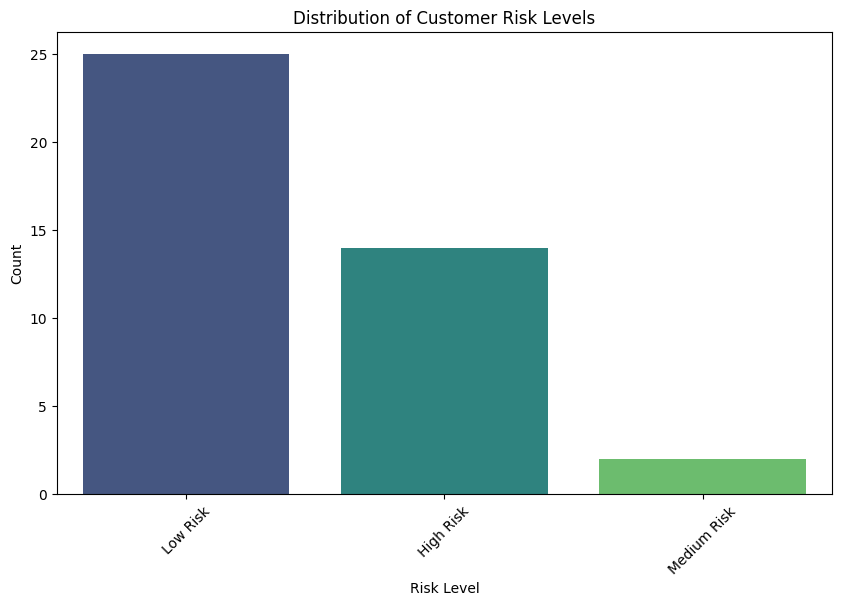

In [52]:
# Visualizing the distribution of the target variable 'Risk Level'
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Risk Level', palette='viridis')
plt.title('Distribution of Customer Risk Levels')
plt.xlabel('Risk Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

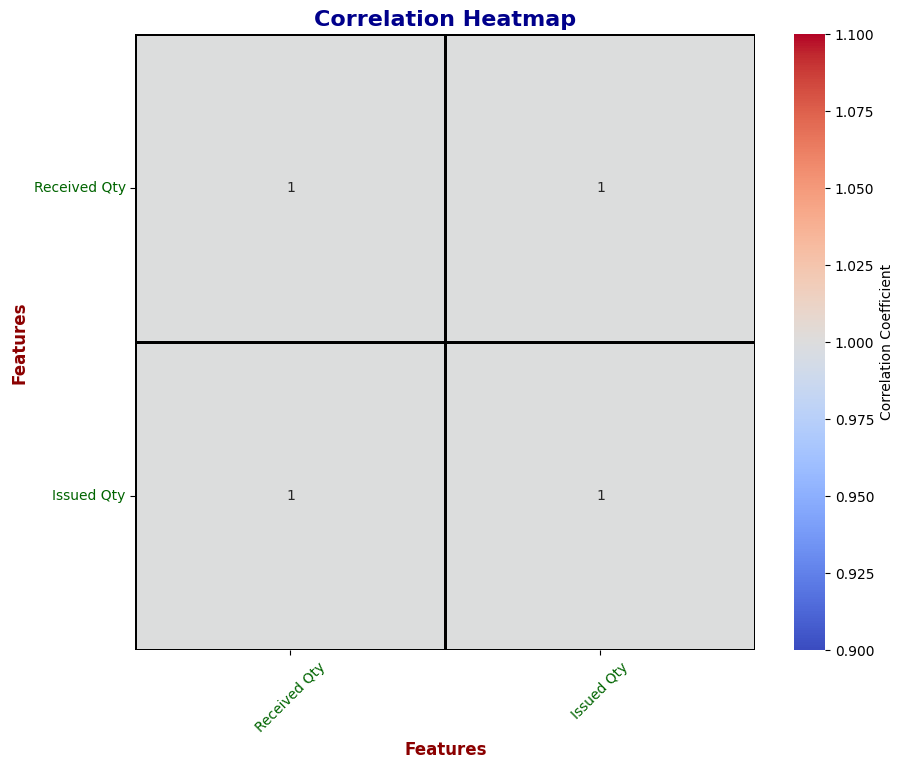

In [53]:
# Visualizing the correlation heatmap for the numerical columns
plt.figure(figsize=(10, 8))

 # Update numerical_cols to reflect stripped column names
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns

# The Correlation Heatmap
sns.heatmap(
    data[numerical_cols].corr(),
    annot=True,
    cmap='coolwarm',
    cbar_kws={'label': 'Correlation Coefficient'},
    linewidths=1,
    linecolor='black'
)

# Adding title and labels with formatting
plt.title('Correlation Heatmap', fontsize=16, fontweight='bold', color='darkblue')
plt.xlabel('Features', fontsize=12, fontweight='bold', color='darkred')
plt.ylabel('Features', fontsize=12, fontweight='bold', color='darkred')

# Customizing tick labels for better readability
plt.xticks(fontsize=10, rotation=45, color='darkgreen')
plt.yticks(fontsize=10, rotation=0, color='darkgreen')

# Display the heatmap
plt.show()

<ipython-input-54-1770f3e04352>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=column, palette='viridis')


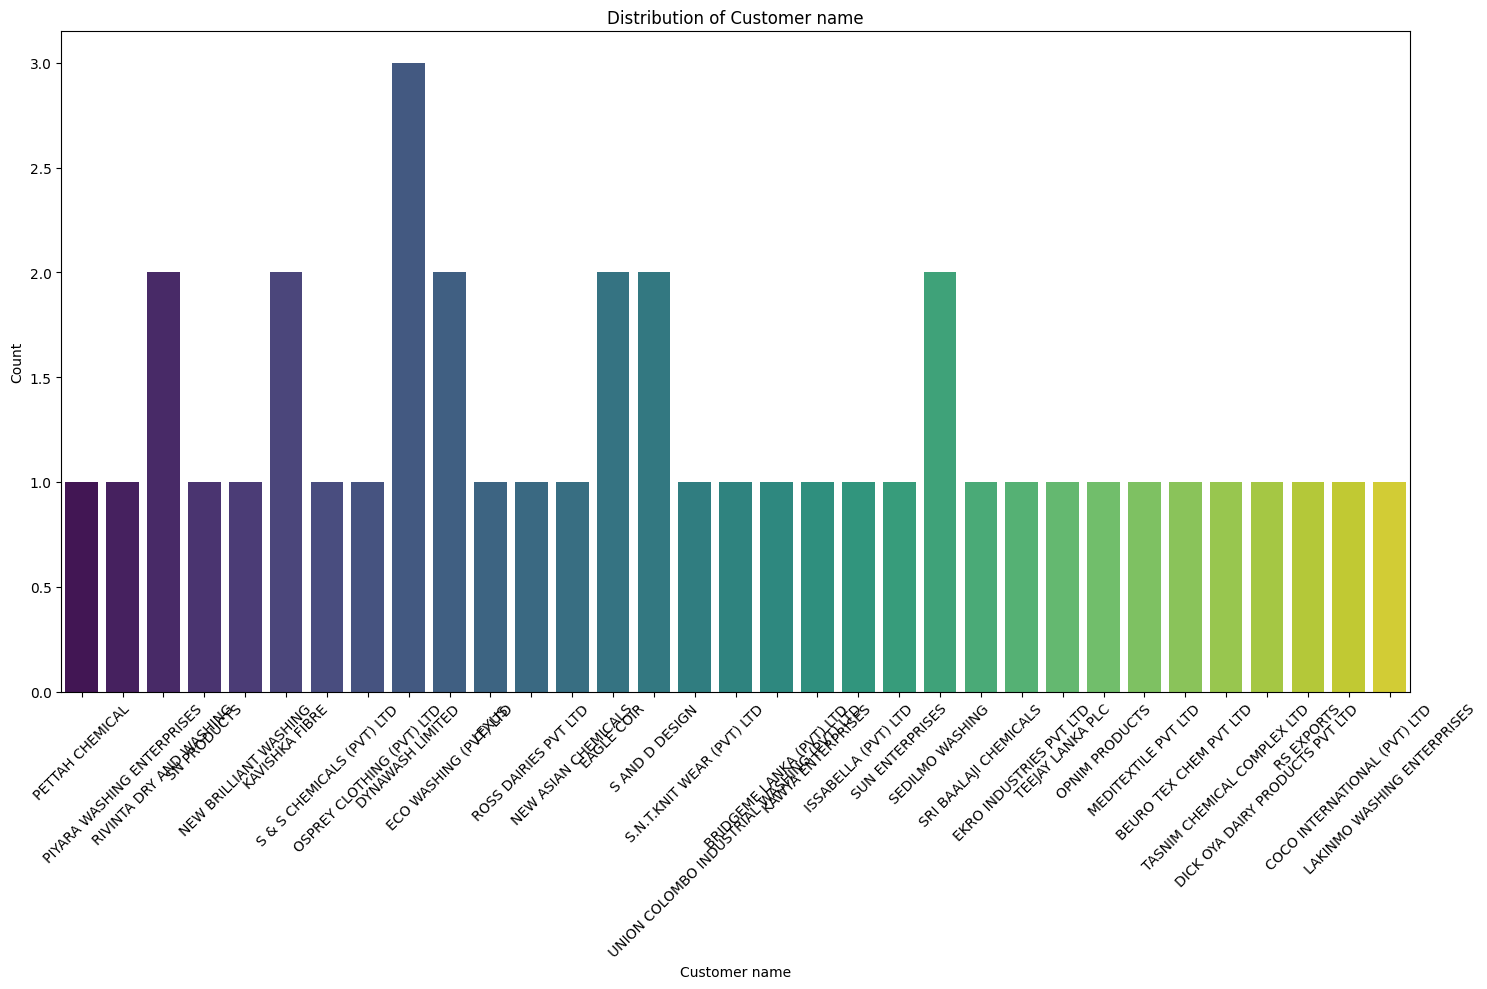

In [54]:
# Defining a list to store the categorical variables
categorical_columns = [ 'Customer name']

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Loop through each categorical column and create a bar plot
for i, column in enumerate(categorical_columns):
    plt.subplot(len(categorical_columns), 1, i + 1)  # Create a subplot for each column
    sns.countplot(data=data, x=column, palette='viridis')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)  # Rotate x labels for better readability

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


<ipython-input-55-a660536658c3>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=column, palette='viridis')
<ipython-input-55-a660536658c3>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=column, palette='viridis')


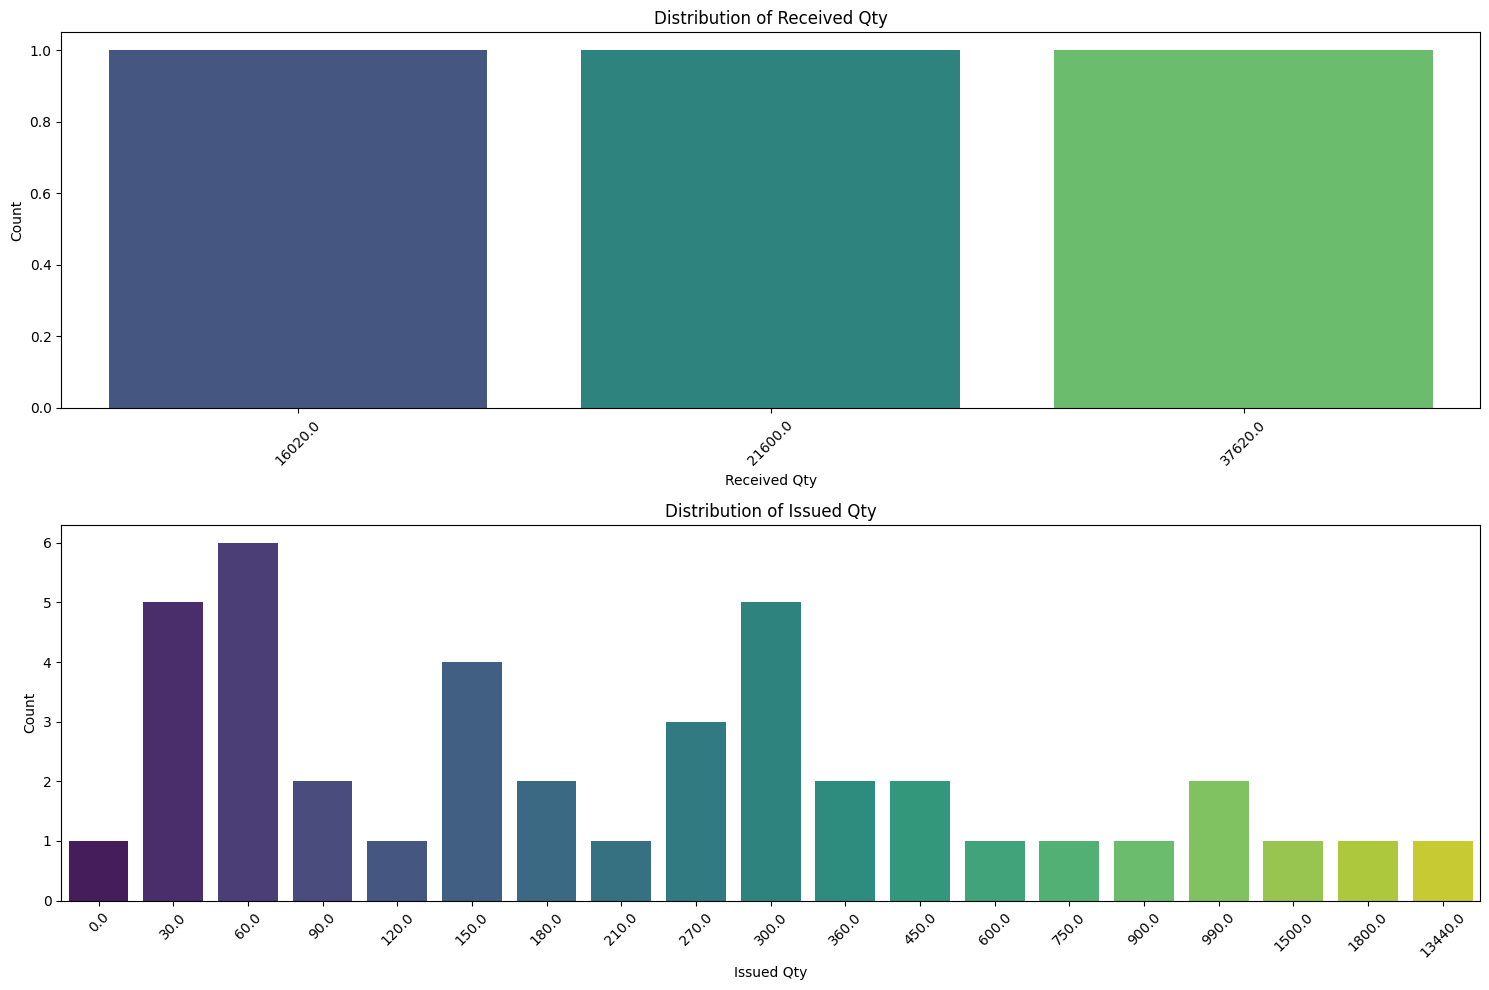

In [55]:
# Defining a list to store the numerical variables
numerical_columns = ['Received Qty', 'Issued Qty'] # Remove trailing spaces

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Loop through each categorical column and create a bar plot
for i, column in enumerate(numerical_columns):
    plt.subplot(len(numerical_columns), 1, i + 1)  # Create a subplot for each column
    sns.countplot(data=data, x=column, palette='viridis')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)  # Rotate x labels for better readability

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [56]:
# Strip any leading or trailing spaces from column names
data.columns = data.columns.str.strip()

# Select numerical columns for outlier detection
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Function to detect outliers using the IQR method
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Check for outliers in each numerical column
outlier_summary = {}
for col in numerical_columns:
    outliers = detect_outliers_iqr(data, col)
    outlier_summary[col] = len(outliers)

# Display the number of outliers for each numerical column
outlier_summary_df = pd.DataFrame(outlier_summary.items(), columns=['Column', 'Number of Outliers'])
print(outlier_summary_df)

         Column  Number of Outliers
0  Received Qty                   0
1    Issued Qty                   6


#**Data Preprocessing**

---



In [57]:
# Step 1: Removing whitespaces from the object type columns
object_columns = data.select_dtypes(include=['object']).columns
data[object_columns] = data[object_columns].apply(lambda x: x.str.strip())

# Step 2: Identifying and displaying duplicate values
print(f"Initial dataset shape: {data.shape}")

# Identify duplicates
duplicates = data[data.duplicated(keep=False)]  # Keep all duplicates for display
print(f"Number of duplicate rows found: {duplicates.shape[0]}")

# Remove duplicate values
data = data.drop_duplicates()
print(f"Shape after removing duplicates: {data.shape}")

Initial dataset shape: (87, 9)
Number of duplicate rows found: 44
Shape after removing duplicates: (44, 9)


In [58]:
# Step 3: Handling missing values in the Categorical Columns

# Checking for missing values in the Categorical Columns
for column in categorical_cols:
    print(f"Missing values for column {column}: {data[column].isnull().sum()}")

Missing values for column Warehouse: 1
Missing values for column Product code: 3
Missing values for column Invoice No: 3
Missing values for column UOM: 3
Missing values for column Customer name: 3


In [59]:
# Step 4: Handling missing values in the Numerical Columns

# Checking for missing values in the Numerical Columns
for column in numerical_cols:
    print(f"Missing values for column {column}: {data[column].isnull().sum()}")

Missing values for column Received Qty: 41
Missing values for column Issued Qty: 2


In [60]:
# All categorical columns are encoded using the label encoding since the categorical data contained within the dataset are ordinal

# Step 5: Encoding the categorical columns

# Defining the columns to be encoded
encoding_cols = ['Warehouse', 'Product code', 'Invoice No', 'UOM', 'Customer name', 'Risk Level']

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to each categorical column
for column in encoding_cols:
    data[column] = label_encoder.fit_transform(data[column])  # Convert to string to handle NaN values

# Display the first few rows of the updated DataFrame
data.head()

,Warehouse,Product code,Invoice No,Transaction Date,UOM,Received Qty,Issued Qty,Customer name,Risk Level
0,1,1,41,NaT,1,16020.0,0.0,33,3
1,0,0,2,2024-10-11,0,NaN,150.0,18,1
2,0,0,3,2024-10-11,0,NaN,30.0,19,1
3,0,0,4,2024-10-12,0,NaN,180.0,20,1
4,0,0,5,2024-10-15,0,NaN,60.0,27,1


In [62]:
# Step 5: Scaling the Numerical Features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[numerical_cols])

# Step 6: Handling the columns with low correlation coefficients with the target column
correlation_with_target = data.corr()['Risk Level'].sort_values(ascending=False)

# Print the correlation values
print("Correlation with Risk Level:")
print(correlation_with_target)

Correlation with Risk Level:
Risk Level          1.000000
Product code        0.735243
UOM                 0.735243
Warehouse           0.677173
Customer name       0.472562
Issued Qty          0.371885
Received Qty        0.268784
Invoice No          0.187413
Transaction Date   -0.735268
Name: Risk Level, dtype: float64


In [63]:
# Dropping the columns with low correlation
columns_to_drop = ['Transaction Date']
data = data.drop(columns=columns_to_drop)

In [64]:
# Dataset Information
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44 entries, 0 to 86
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Warehouse      44 non-null     int64  
 1   Product code   44 non-null     int64  
 2   Invoice No     44 non-null     int64  
 3   UOM            44 non-null     int64  
 4   Received Qty   3 non-null      float64
 5   Issued Qty     42 non-null     float64
 6   Customer name  44 non-null     int64  
 7   Risk Level     44 non-null     int64  
dtypes: float64(2), int64(6)
memory usage: 3.1 KB


In [67]:
# Step 7: Splitting Features and the Target Variable
X = data.drop(columns=['Risk Level'])
y = data['Risk Level']

# Step 8: Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Analyzing the distribution of the y train dataset
y_train.value_counts(normalize=True)

,proportion
Risk Level,
1,0.514286
0,0.342857
3,0.085714
2,0.057143


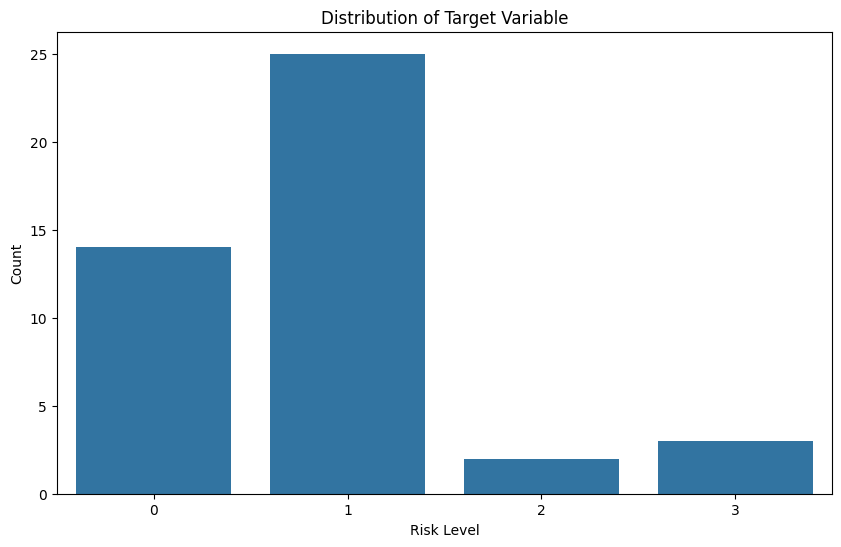

In [69]:
# Visualizing the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Risk Level')
plt.xticks(rotation=0)
plt.title('Distribution of Target Variable')
plt.xlabel('Risk Level')
plt.ylabel('Count')
plt.show()

In [70]:
# Displaying the dataset shape
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (35, 7)
Shape of X_test: (9, 7)
Shape of y_train: (35,)
Shape of y_test: (9,)


In [81]:
# Step 1: Check for class imbalance in the 'Risk Level' column
class_distribution = data['Risk Level'].value_counts()

# Print the distribution of classes
print("Class distribution in 'Risk Level':")
print(class_distribution)


Class distribution in 'Risk Level':
Risk Level
1    25
0    14
3     3
2     2
Name: count, dtype: int64


Original dataset size: (44, 7)
Resampled dataset size: (100, 7)


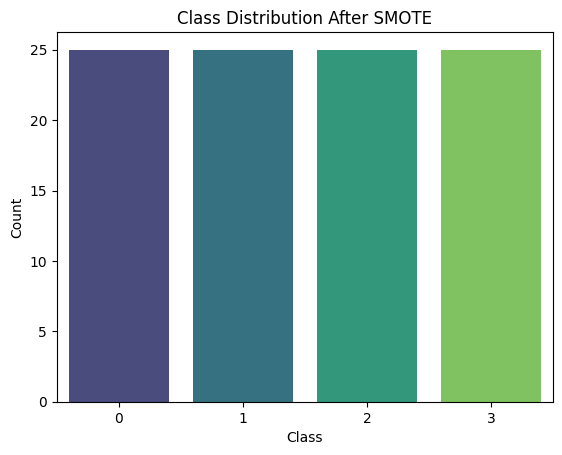

In [80]:
# Suppressing the FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Handling imbalanced dataset
smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=1)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Original dataset size:", X.shape)
print("Resampled dataset size:", X_resampled.shape)

# Plotting class distribution after SMOTE
sns.countplot(x=y_resampled, palette="viridis")
plt.title("Class Distribution After SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()